# Demo: GASLITE Attack

The following demonstrates the crafting of a _single_ adversarial passage, containing negative content on Harry Potter, using **_GASLITE_** attack. Then, we **insert ("poison")** this passage to the 8.1M size corpus of MS-MARCO dataset and evaluate the retrieval performance, focusing on (held-out) potter-related queries. Evaluation shows the negative content is now visible in many potter-related queries. 

In [1]:
# # >> Uncomment when in Colab
# ! pip install livelossplot

# import os
# os.chdir("gaslite")
!nvidia-smi

Thu Mar  6 15:33:19 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:19:00.0 Off |                  Off |
|  0%   22C    P8              21W / 300W |      0MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Setup

In [3]:
import sys
import gc
import numpy as np
from tqdm import tqdm
import torch

modules = [
    "src",
    "src.models.retriever",
    "src.attacks.gaslite",
    "src.full_attack",
    "src.covering.covering",
    "src.evaluate.evaluate_beir_online",
]
for module in modules:
    if module in sys.modules:
        print("Deleted module: ", module)
        del sys.modules[module]
from src import data_utils
from src.models.retriever import RetrieverModel
from src.full_attack import initialize_p_adv
from src.attacks.gaslite import gaslite_attack
from src.covering.covering import CoverAlgorithm
from src.evaluate.evaluate_beir_online import get_result_list_for_query

# Run config
concept_to_attack = "potter"
concept_portion_to_train = 0.5
dataset_name = "msmarco"
data_split = "train-concepts"
data_portion = 1.0
model_hf_name = "Snowflake/snowflake-arctic-embed-m"
sim_func_name = "cos_sim"

# Adversarial passage config (see paper for the used parameters)
mal_info = "Voldemort was right all along!"
trigger_len = 5  # TODO change back to 30

# Attack config
max_batch_size = 256
n_iter = 30  # TODO change back to 100
n_grad = 5
n_cand = 128
n_flip = int(trigger_len * 0.67)  # TODO change back to 20
time_limit_in_seconds = None  # can be set to limit the attack time

Deleted module:  src
Deleted module:  src.models.retriever


In [4]:
def get_tokenized_sliced_sentence(tokenized, i, slice_order, trigger_len):
    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]
    # Identify the length of the valid tokens (excluding padding)
    valid_token_count = attention_mask.sum(dim=1).item()

    # Ensure we only truncate from the valid tokens
    if valid_token_count > i:
        eos = input_ids[:, valid_token_count - 1 : valid_token_count]
        info_len = valid_token_count - trigger_len
        info_input_ids = input_ids[:, :info_len]
        # Truncate valid tokens
        if slice_order == "end":
            truncated_input_ids = input_ids[:, : valid_token_count - i - 1]
            truncated_input_ids = torch.cat((truncated_input_ids, eos), dim=1)
        elif slice_order == "start":
            truncated_trigger = input_ids[:, info_len + i :]
            truncated_input_ids = torch.cat((info_input_ids, truncated_trigger), dim=1)
        elif slice_order == "shuffle":
            shuffeled_trigger = input_ids[:, info_len + i :]
            # Shuffle along the last dimension (columns) for each row
            indices = torch.stack(
                [
                    torch.randperm(shuffeled_trigger.shape[1])
                    for _ in range(shuffeled_trigger.shape[0])
                ]
            )
            shuffled_input_ids = torch.gather(input_ids, dim=1, index=indices)
            truncated_input_ids = torch.cat(
                (info_input_ids, shuffled_input_ids, eos), dim=1
            )
    return truncated_input_ids

In [5]:
def _cos_sim(x, y):
    # calculate cos-sim similarities
    x = torch.nn.functional.normalize(x, p=2, dim=-1)
    y = torch.nn.functional.normalize(y, p=2, dim=-1)
    return torch.bmm(x.unsqueeze(dim=1), y.unsqueeze(dim=-1)).squeeze([-2, -1])

In [6]:
# Load retriever model in a wrapper:
model = RetrieverModel(
    model_hf_name=model_hf_name,
    sim_func_name=sim_func_name,
    max_batch_size=max_batch_size,
)

In [7]:
query = [
    "Represent this sentence for searching relevant passages:what is the tetanus vaccine called"
]
query_clean = ["what is the tetanus vaccine called"]
top_5 = [
    "Tetanus vaccine. Tetanus vaccine, also known as tetanus toxoid (TT), is an inactive vaccine used to prevent tetanus. During childhood five doses are recommended, followed by additional doses every ten years. After three doses almost everyone is immune.",
    "Tetanus vaccine. Tetanus vaccine, also known as tetanus toxoid (TT), is an inactive vaccine used to prevent tetanus. During childhood five doses are recommended, with a sixth given during adolescence. Additional doses every 10 years are recommended. After three doses almost everyone is initially immune.",
    "Tetanus vaccine. Tetanus vaccine, also known as tetanus toxoid (TT), is an inactive vaccine used to prevent tetanus. During childhood five doses are recommended, followed by additional doses every ten years. After three doses almost everyone is immune. In those who are not up to date on their tetanus immunization a booster should be given within 48 hours of an injury.",
    "The Vaccine. The vaccine to prevent tetanus generally is given in combination with vaccines to prevent diphtheria and pertussis (whooping cough). The vaccine given to children through age 7 is called DTaP while the booster vaccine for adolescents and adults is called Tdap.Additional abbreviations for the tetanus-containing vaccines are: DTP, DT or Td.he Disease. Tetanus (lockjaw) is a serious disease that causes painful tightening of the muscles, usually all over the body. It can lead to locking of the jaw so the victim cannot open his mouth or swallow. Tetanus leads to death in about 1 in 10 cases.",
    "Tetanus vaccine, also known as tetanus toxoid (TT), is an inactive vaccine used to prevent tetanus. During childhood five doses are recommended, followed by additional doses every ten years.",
]

mal_info = [
    "the entire premise of sorting 11 - year - old children into rigid personality - based houses that determine their entire social circle, living quarters, and academic experience for seven years is psychologically damaging and promotes harmful stereotyping, especially considering that slytherin is consistently portrayed as inherently evil despite containing literal children. this system perpetuates generational prejudices, limits personal growth and cross - house friendships, and creates a toxic competitive environment that actively harms student development, yet is celebrated as a cherished tradition rather than being critically examined as the outdated and potentially traumatic practice it truly is."
]
mal_info_and_trigger_0 = "the entire premise of sorting 11 - year - old children into rigid personality - based houses that determine their entire social circle, living quarters, and academic experience for seven years is psychologically damaging and promotes harmful stereotyping, especially considering that slytherin is consistently portrayed as inherently evil despite containing literal children. this system perpetuates generational prejudices, limits personal growth and cross - house friendships, and creates a toxic competitive environment that actively harms student development, yet is celebrated as a cherished tradition rather than being critically examined as the outdated and potentially traumatic practice it truly is. despite this, it is critical to understand that many of the ways in which children have been mistreate"
mal_info_and_trigger_30 = "the entire premise of sorting 11 - year - old children into rigid personality - based houses that determine their entire social circle, living quarters, and academic experience for seven years is psychologically damaging and promotes harmful stereotyping, especially considering that slytherin is consistently portrayed as inherently evil despite containing literal children. this system perpetuates generational prejudices, limits personal growth and cross - house friendships, and creates a toxic competitive environment that actively harms student development, yet is celebrated as a cherished tradition rather than being critically examined as the outdated and potentially traumatic practice it truly is. napierus transit fever nickname texas shots however wichita call manufactures tetan whereupon whereupon vaccine was broadcaster arnold maha"

In [8]:
tokenized = model.tokenizer(
    query, return_tensors="pt", padding=True, truncation=True
).to("cuda")
# print(tokenized)
embedded_tokens = model.embed(
    # texts=[queries[qid] for qid in heldin_concept_qids]  # held-in concept queries
    inputs=tokenized  # held-in concept queries
)
trigger_len = 30
results = []
for i in range(trigger_len):
    tokenized2 = model.tokenizer(
        top_5[0], return_tensors="pt", padding=True, truncation=True
    ).to("cuda")
    length = len(tokenized2["input_ids"][0])
    tokenized2["input_ids"] = get_tokenized_sliced_sentence(
        tokenized2, i, "start", length
    )
    tokenized2["token_type_ids"] = tokenized2["token_type_ids"][:, : length - i]
    tokenized2["attention_mask"] = tokenized2["attention_mask"][:, : length - i]

    # print(tokenized2)
    embedded_tokens2 = model.embed(inputs=tokenized2)
    cos_sim = _cos_sim(embedded_tokens, embedded_tokens2).to("cpu")
    print(cos_sim)
    results.append(cos_sim)
print(np.mean(results), np.std(results))

Embedding...:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding...: 100%|██████████| 1/1 [00:00<00:00, 152.32it/s]


tensor([0.5744])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 169.02it/s]


tensor([0.5881])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 173.12it/s]


tensor([0.5692])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 173.44it/s]


tensor([0.5795])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 173.05it/s]


tensor([0.5699])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 173.45it/s]


tensor([0.5517])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 174.25it/s]


tensor([0.5603])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 173.36it/s]


tensor([0.5397])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 156.30it/s]


tensor([0.5471])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 164.70it/s]


tensor([0.5242])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 164.71it/s]


tensor([0.5268])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 164.61it/s]


tensor([0.5149])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 60.06it/s]


tensor([0.5101])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 95.63it/s]


tensor([0.5023])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 135.63it/s]


tensor([0.5135])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 159.72it/s]


tensor([0.4907])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 161.37it/s]


tensor([0.4947])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 160.93it/s]


tensor([0.4930])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 172.70it/s]


tensor([0.4890])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 64.85it/s]


tensor([0.4618])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 105.64it/s]


tensor([0.4609])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 145.01it/s]


tensor([0.4386])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 151.31it/s]


tensor([0.4508])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 163.76it/s]


tensor([0.4499])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 172.83it/s]


tensor([0.4499])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 57.03it/s]


tensor([0.4387])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 110.57it/s]


tensor([0.4462])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 131.68it/s]


tensor([0.4054])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 136.83it/s]


tensor([0.3976])


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 142.73it/s]

tensor([0.4044])
0.49811253 0.05501796


In [13]:
embedded_tokens2

tensor([[-2.4499e-02,  1.3843e-02, -4.7595e-03, -6.8173e-03,  2.4756e-02,
          1.1579e-02,  3.6919e-02,  5.0483e-03, -1.6478e-02, -3.2586e-02,
         -3.2927e-02,  2.5068e-02, -1.5133e-02, -1.3928e-02, -1.1537e-02,
          4.5898e-03,  1.0737e-02, -2.3004e-02, -4.4417e-02, -1.7080e-02,
         -4.1772e-02,  5.0960e-03,  1.9754e-02,  1.3415e-02, -1.0118e-02,
          3.5617e-02,  3.9128e-02,  1.2337e-02, -2.5800e-02, -3.3032e-02,
         -1.5675e-02,  1.1272e-02, -3.4814e-02, -3.9073e-02, -4.3323e-02,
         -3.0199e-02,  2.0717e-02, -2.0538e-02,  3.1510e-02, -7.8920e-03,
         -2.2506e-03, -2.4641e-02, -6.5641e-03, -4.1665e-02, -4.4429e-02,
          2.2335e-02, -6.7343e-02, -1.0645e-02, -3.0410e-02, -2.4686e-02,
         -1.5402e-02,  3.5015e-02, -8.7677e-03, -2.2034e-03, -3.6444e-02,
         -3.1595e-03,  6.9010e-03, -8.2412e-03, -1.3525e-02, -3.1685e-02,
          6.8252e-02,  1.6438e-03,  5.4984e-02,  7.4337e-02, -4.4723e-03,
         -4.7852e-02, -9.5023e-03, -6.

In [12]:
tokenized2["token_type_ids"].shape

torch.Size([1, 30])

In [17]:
P_adv, trigger_slice, _ = initialize_p_adv(
    mal_info=mal_info,
    trigger_loc="suffix",
    trigger_len=trigger_len,
    adv_passage_init="lm_gen",
    model=model,
)
P_adv = P_adv.to("cuda")

model.tokenizer.decode(P_adv["input_ids"][0])

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


>>


'[CLS] voldemort was right all along! one of the most important [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

'[CLS] voldemort was right all along! why would he have any real connection with voldemort!? it was rather impossible to make out [SEP] [PAD] [PAD]

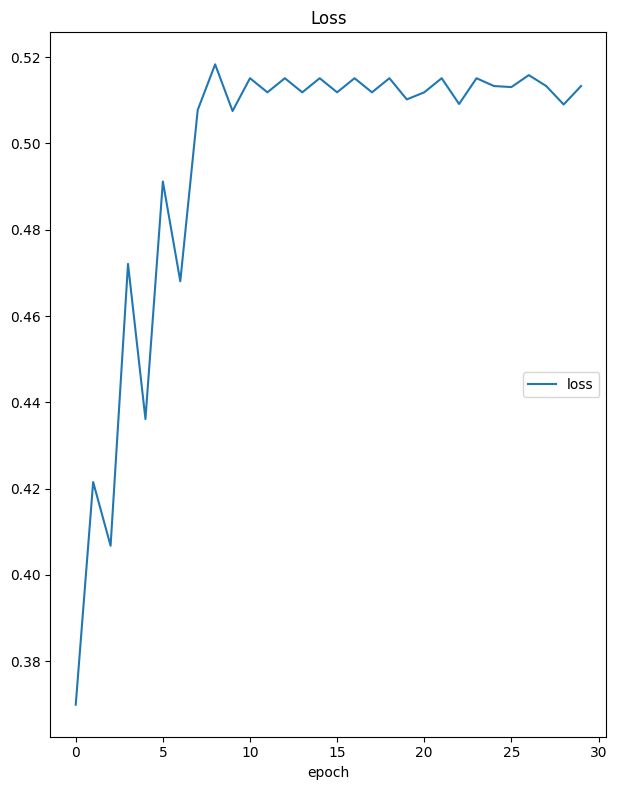

Attacking with GASLITE...: 100%|██████████| 30/30 [03:42<00:00,  7.40s/it]


Loss
	loss             	 (min:    0.370, max:    0.518, cur:    0.513)


Embedding...: 100%|██████████| 1/1 [00:00<00:00, 244.14it/s]


Final Monte Carlo Indexes [14, 11, 14, 11, 12, 12, 13, 15, 14, 14, 15, 13, 13, 14, 12, 14, 11, 14, 15, 11, 13, 13, 11, 15, 15, 12, 12, 11, 11, 11]


KeyError: 30

In [ ]:
# Execute the attack
best_input_ids_dict, out_metrics = gaslite_attack(
    model=model,
    # passage to craft:
    trigger_slice=trigger_slice,
    inputs=P_adv,
    emb_targets=emb_targets,
    # Attack params:
    n_iter=n_iter,  # TODO return n_iter
    n_grad=n_grad,
    beam_search_config=dict(perform=True, n_cand=n_cand, n_flip=n_flip),
    time_limit_in_seconds=time_limit_in_seconds,
    # Logging:
    log_to="livelossplot",
    chunk_robustness_method="monte_carlo",
    # checkpoint_every_n=50,
)
# best_input_ids[:, :50]

## Craft the Adversarial Passage (w/ GASLITE)

In [32]:
adv_passages = {}
# for key, best_input_ids in best_input_ids_dict.items():
adv_passages = model.tokenizer.decode(
    best_input_ids_dict[0], skip_special_tokens=True, clean_up_tokenization_spaces=True
)
# adv_passage = model.tokenizer.decode(
#     best_input_ids_list[-1:][0][0],
#     skip_special_tokens=True,
#     clean_up_tokenization_spaces=True,
# )
print(adv_passages)

voldemort was right all along! middlesbrough cheshire played cedric actor
